# Pipeline

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

%matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2

## 1D Cases

In [2]:
hole = np.array([-1, 1])
obj = np.array([-0.3, 1.3])
# initial_guess_left = scipy.stats.norm(hole[0], 0.5)
initial_guess_left = scipy.stats.norm(obj[0], 0.1)
# initial_guess_right = scipy.stats.norm(hole[1], 0.5)
initial_guess_right = scipy.stats.norm(obj[1], 0.1)
mean = np.array([initial_guess_left.mean(), initial_guess_right.mean()])
disp = mean.mean()
mean -= disp
obj -= disp
std = np.array([initial_guess_left.std(), initial_guess_right.std()])
guess = [scipy.stats.norm(mean[i], std[i]) for i in range(2)]

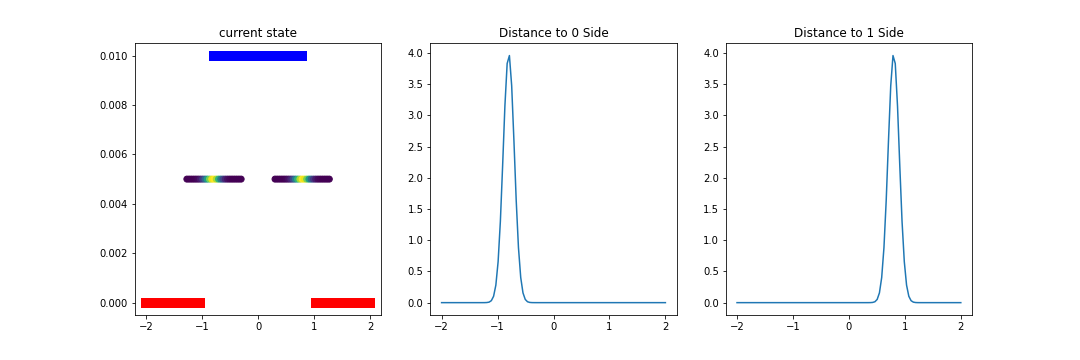

In [3]:
fig = plt.figure(figsize=(15,5))

# Plot scene
x_grid = np.linspace(-2, 2, 100)

ax = fig.add_subplot(1, 3, 1)
mask = x_grid>hole[1] 
ax.plot(x_grid[mask], np.zeros(mask.sum()), 'r', linewidth=10)
mask = x_grid<hole[0] 
ax.plot(x_grid[mask], np.zeros((mask).sum()), 'r', linewidth=10)
mask = (x_grid>obj[0]) & (x_grid<obj[1])
ax.plot(x_grid[mask], np.ones((mask).sum())*0.01, 'b', linewidth=10)

# plot initial guess
for i in range(2):
  mask = (x_grid<(mean[i]+0.5)) & (x_grid > mean[i]-0.5)
  color = guess[i].pdf(x_grid[mask])
  ax.scatter(x_grid[mask], np.ones(mask.sum())*0.005, c=color, cmap='viridis', linewidths=1)

ax.title.set_text('current state')


# Plot Two side distribution
for i in range(2):
  ax = fig.add_subplot(1, 3, i+2)
  ax.plot(x_grid, guess[i].pdf(x_grid))
  ax.title.set_text(f'Distance to {i} Side')


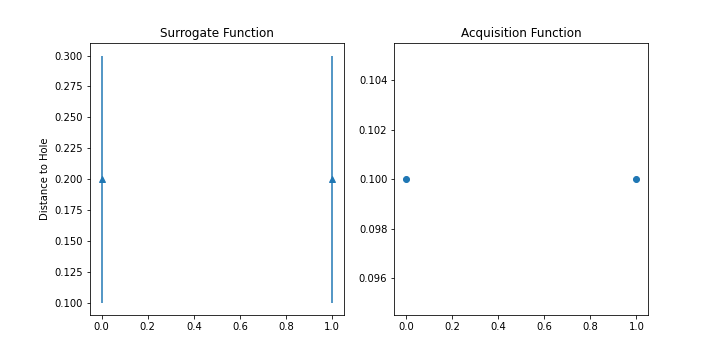

In [4]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1, 2, 1)
ax.errorbar([0,1], [mean[0]-hole[0], hole[1]-mean[1]], std, linestyle='None', marker='^')
ax.title.set_text('Surrogate Function')
ax.set_ylabel('Distance to Hole')

ax = fig.add_subplot(1, 2, 2)
ax.scatter([0,1], [initial_guess_left.std(), initial_guess_right.std()])
ax.title.set_text('Acquisition Function')

# 2D Cases

In [5]:
from scipy.ndimage import gaussian_filter1d
import gpytorch
import torch
from tqdm import trange

In [6]:
n_sample = 36
X = np.linspace(0, (1+1/n_sample)*2*np.pi, n_sample+1).reshape(-1,1)[:-1]
y = np.ones(X.shape[0])
for i in range(-3, 3):
  i %= 36
  y[i] = 1/np.abs(np.cos(X[i]))
for i in range(3, 15):
  y[i] = 0.57735/np.abs(np.cos(np.pi/2-X[i]))
for i in range(15, 21):
  y[i] = 1/np.abs(np.cos(X[i]))
for i in range(21, 33):
  y[i] = 0.57735/np.abs(np.cos(3*np.pi/2-X[i]))

hole_half_size = 0.7

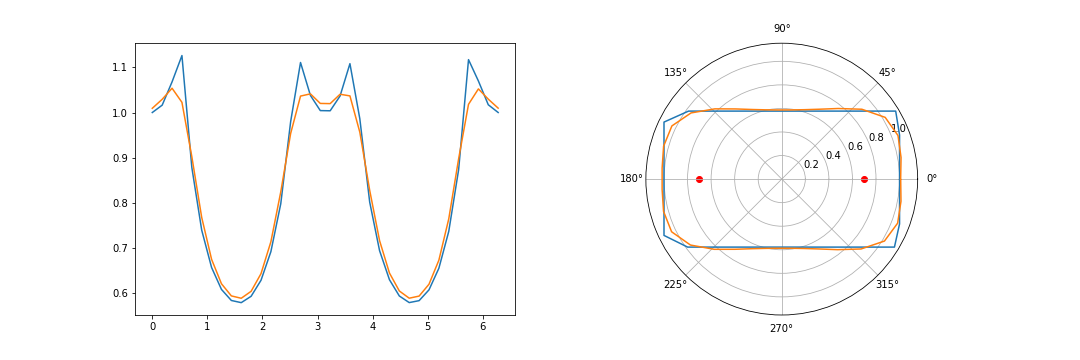

In [7]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1)
ysmoothed = gaussian_filter1d(y, sigma=1)
ax.plot(X, y)
ax.plot(X, ysmoothed)
ax = fig.add_subplot(1, 2, 2, projection='polar')
ax.plot(X, y)
ax.plot(X, ysmoothed)
ax.scatter(0, hole_half_size, color='red',)
ax.scatter(np.pi, hole_half_size, color='red')
y = ysmoothed

In [8]:
y_mean = y.mean()
y_std = y.std()
y_normed = (y-y_mean)/y_std

Start from Here

In [9]:
train_index = [0, 18, 9, 13, 4, 27]
train_index = np.append(train_index, 35)
x_train = torch.tensor(X[train_index])
y_train = torch.tensor(y_normed[train_index])

In [10]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood):
    super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = gpytorch.kernels.ScaleKernel(
      gpytorch.kernels.RBFKernel())

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.zeros_like(y_train, dtype=torch.float64))
model = ExactGPModel(x_train, y_train, likelihood)


/juno/u/chaoyi/miniconda3/envs/rl/lib/python3.9/site-packages/gpytorch/likelihoods/noise_models.py:145: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


In [11]:
hypers = {
  'covar_module.base_kernel.lengthscale': torch.tensor(0.4),
}
model_params = model.initialize(**hypers)

In [12]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

train_num = 20
for i in (pbar := trange(train_num)):
  # Zero gradients from previous iteration
  optimizer.zero_grad()
  # Output from model
  output = model(x_train)
  loss = -mll(output, y_train)
  loss.backward()
  pbar.set_description(f'Iter {i+1}/{train_num} - Loss: {loss.item():.3f}, lengthscale: {model.covar_module.base_kernel.lengthscale.item():.3f}')
  optimizer.step()

  0%|          | 0/20 [00:00<?, ?it/s]/juno/u/chaoyi/miniconda3/envs/rl/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
Iter 20/20 - Loss: 1.376, lengthscale: 0.588: 100%|██████████| 20/20 [00:00<00:00, 174.95it/s]


In [13]:

n_eval = 120
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  x_pred = torch.linspace(0, 2*torch.pi, n_eval+1, dtype=torch.float64)
  observed_pred = likelihood(model(x_pred))

y_pred = (observed_pred.mean*y_std+y_mean).numpy()
y_pred_std = (observed_pred.stddev*y_std).numpy()
y_lower, y_upper = observed_pred.confidence_region()
y_lower = y_lower.numpy() * y_std + y_mean
y_upper = y_upper.numpy() * y_std + y_mean

/juno/u/chaoyi/miniconda3/envs/rl/lib/python3.9/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


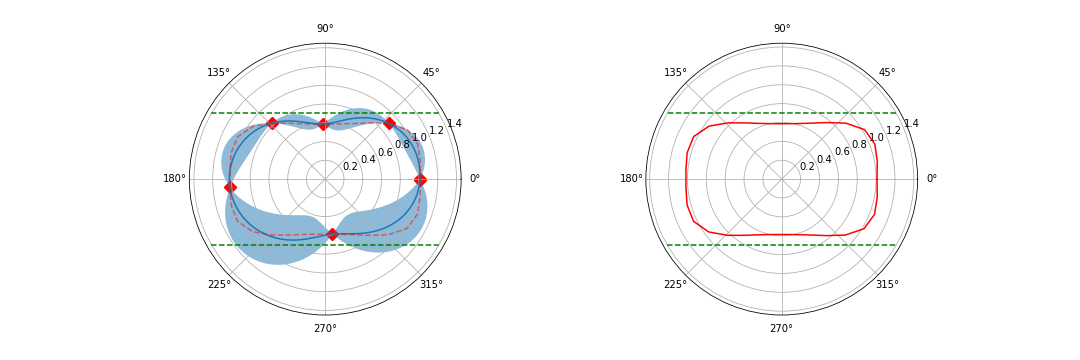

In [14]:
x_line = np.linspace(np.pi/6, np.pi*5/6, 20)
y_line = hole_half_size / np.sin(x_line)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1, projection='polar')
ax.scatter(x_train.numpy(), y_train.numpy()*y_std+y_mean, c='r', marker='x', linewidth=10)
ax.fill_between(
  x_pred.flatten(),
  y_lower,
  y_upper,
  alpha=0.5,
  label=r"95% confidence interval",
)
ax.plot(x_pred, y_pred)
ax.plot(X, y, 'r--', markersize=15, alpha=0.5)
ax.plot(x_line, y_line, 'g--', markersize=15)
ax.plot(x_line+np.pi, y_line, 'g--', markersize=15)

ax = fig.add_subplot(1, 2, 2, projection='polar')
ax.plot(X, y, 'r', markersize=15)
ax.plot(x_line, y_line, 'g--', markersize=15)
ax.plot(x_line+np.pi, y_line, 'g--', markersize=15)

In [15]:
# calculate the distance to the hole
# The things we need to do is convert gaussian distribution in polar coordinate to cartesian coordinate
# and then calculate the distance to the hole
# p(x,y) = 1/r*p(r,theta)

obj_orn = 0

# left side
if isinstance(x_pred, torch.Tensor):
  x_pred = x_pred.flatten().numpy()
x_pred_rot = (x_pred - obj_orn) % (2*np.pi)
mask_left = x_pred_rot < np.pi

x_pred_left = x_pred_rot[mask_left]
y_pred_left = y_pred[mask_left]
mu_2left = hole_half_size - y_pred_left * np.sin(x_pred_left)
std_2left = y_pred_std[mask_left] * np.sin(x_pred_left)
left_min = np.min(mu_2left)

# right side
mask_right = x_pred_rot > np.pi
x_pred_right = x_pred_rot[mask_right]
y_pred_right = y_pred[mask_right]
mu_2right = hole_half_size + y_pred_right * np.sin(x_pred_right)
std_2right = - y_pred_std[mask_right] * np.sin(x_pred_right)
right_min = np.min(mu_2right)

obj_displacement = (left_min - right_min)/2

dist = np.ones_like(y_pred)*0.63
dist[mask_left] = mu_2left - obj_displacement
dist[mask_right] = mu_2right + obj_displacement
dist_std = np.zeros_like(y_pred)
dist_std[mask_left] = std_2left
dist_std[mask_right] = std_2right

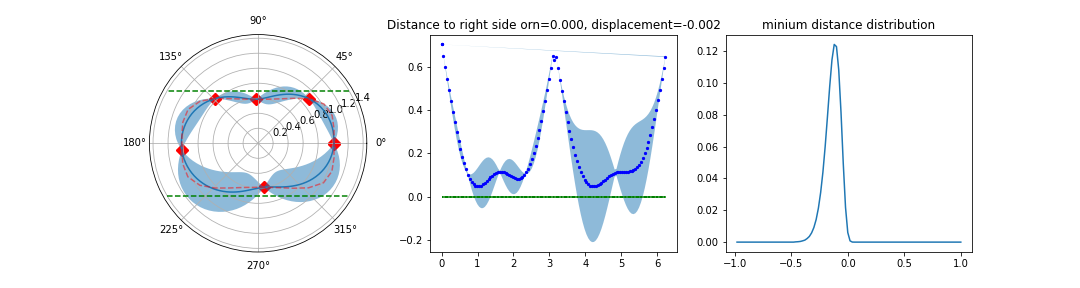

In [16]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,3,1 ,projection='polar')
ax.scatter(x_train.numpy()-obj_orn, y_train.numpy()*y_std+y_mean, c='r', marker='x', linewidth=10)
ax.fill_between(
  x_pred_rot,
  y_lower,
  y_upper,
  alpha=0.5,
  label=r"95% confidence interval",
)
ax.plot(x_pred_rot, y_pred)
ax.plot(X-obj_orn, y, 'r--', markersize=15, alpha=0.5)
ax.plot(x_line, y_line, 'g--', markersize=15)
ax.plot(x_line+np.pi, y_line, 'g--', markersize=15)

ax = fig.add_subplot(1, 3, 2)
ax.fill_between(
  x_pred_rot,
  dist - dist_std*1.95,
  dist + dist_std*1.95,
  alpha=0.5,
  label=r"95% confidence interval",
)
ax.scatter(x_pred_rot, dist, s=5, c='b')
ax.plot(x_pred_rot, np.zeros_like(x_pred), 'g--', markersize=15)
ax.title.set_text(f'Distance to right side orn={obj_orn:.3f}, displacement={obj_displacement:.3f}')

# get minimum distance from the distribution. 
x_min = torch.linspace(-1, 1, 101).unsqueeze(-1)
dist = torch.tensor(dist)
dist_std = torch.tensor(dist_std)
x_normed = (x_min - dist)/dist_std
log_cdf =gpytorch.log_normal_cdf(x_normed) 
mask = log_cdf > -10
cdf = torch.zeros_like(log_cdf)
cdf[mask] = torch.exp(log_cdf[mask])
cdf = torch.prod(1-cdf, dim=1)
pdf = cdf[:-1] - cdf[1:]

ax = fig.add_subplot(1, 3, 3)
ax.plot(x_min[1:].numpy(), pdf.numpy())
ax.title.set_text('minium distance distribution')

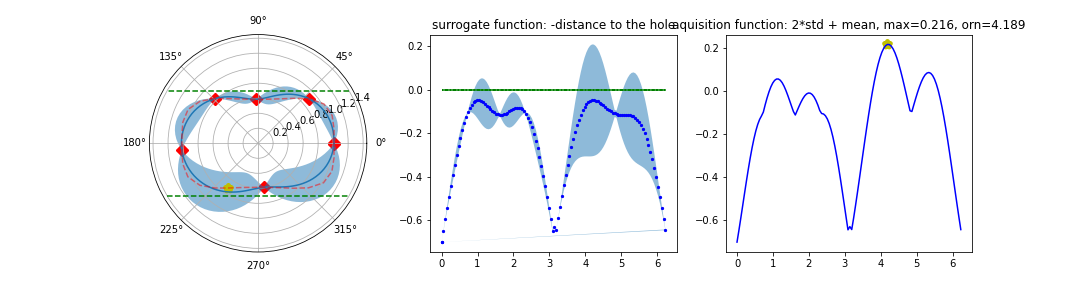

In [17]:
# get surrogate function from the old distribution
fig = plt.figure(figsize=(15,4))

ax = fig.add_subplot(1,3,1 ,projection='polar')
ax.scatter(x_train.numpy()-obj_orn, y_train.numpy()*y_std+y_mean, c='r', marker='x', linewidth=10)
ax.fill_between(
  x_pred_rot,
  y_lower,
  y_upper,
  alpha=0.5,
  label=r"95% confidence interval",
)
ax.plot(x_pred_rot, y_pred)
ax.plot(X-obj_orn, y, 'r--', markersize=15, alpha=0.5)
ax.scatter((X-obj_orn)[23], y[23], c='y', marker='*', linewidth=5)
ax.plot(x_line, y_line, 'g--', markersize=15)
ax.plot(x_line+np.pi, y_line, 'g--', markersize=15)

ax = fig.add_subplot(1,3,2)
ax.fill_between(
  x_pred_rot,
  -(dist - dist_std*1.95),
  -(dist + dist_std*1.95),
  alpha=0.5,
  label=r"95% confidence interval",
)
ax.scatter(x_pred_rot, -dist, s=5, c='b')
ax.plot(x_pred_rot, np.zeros_like(x_pred), 'g--', markersize=15)
ax.title.set_text('surrogate function: -distance to the hole')

ax = fig.add_subplot(1,3,3)
aq = (-dist + dist_std*2)[:-1] 
aq_x = x_pred_rot[:-1]
ax.plot(aq_x, aq, 'b')
aq_max = aq.max()
ax.scatter(aq_x[aq==aq_max], aq_max, c='y', marker='*', linewidth=5)
ax.title.set_text(f'aquisition function: 2*std + mean, max={aq_max:.3f}, orn={aq_x[aq==aq_max][0]:.3f}')

/juno/u/chaoyi/miniconda3/envs/rl/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


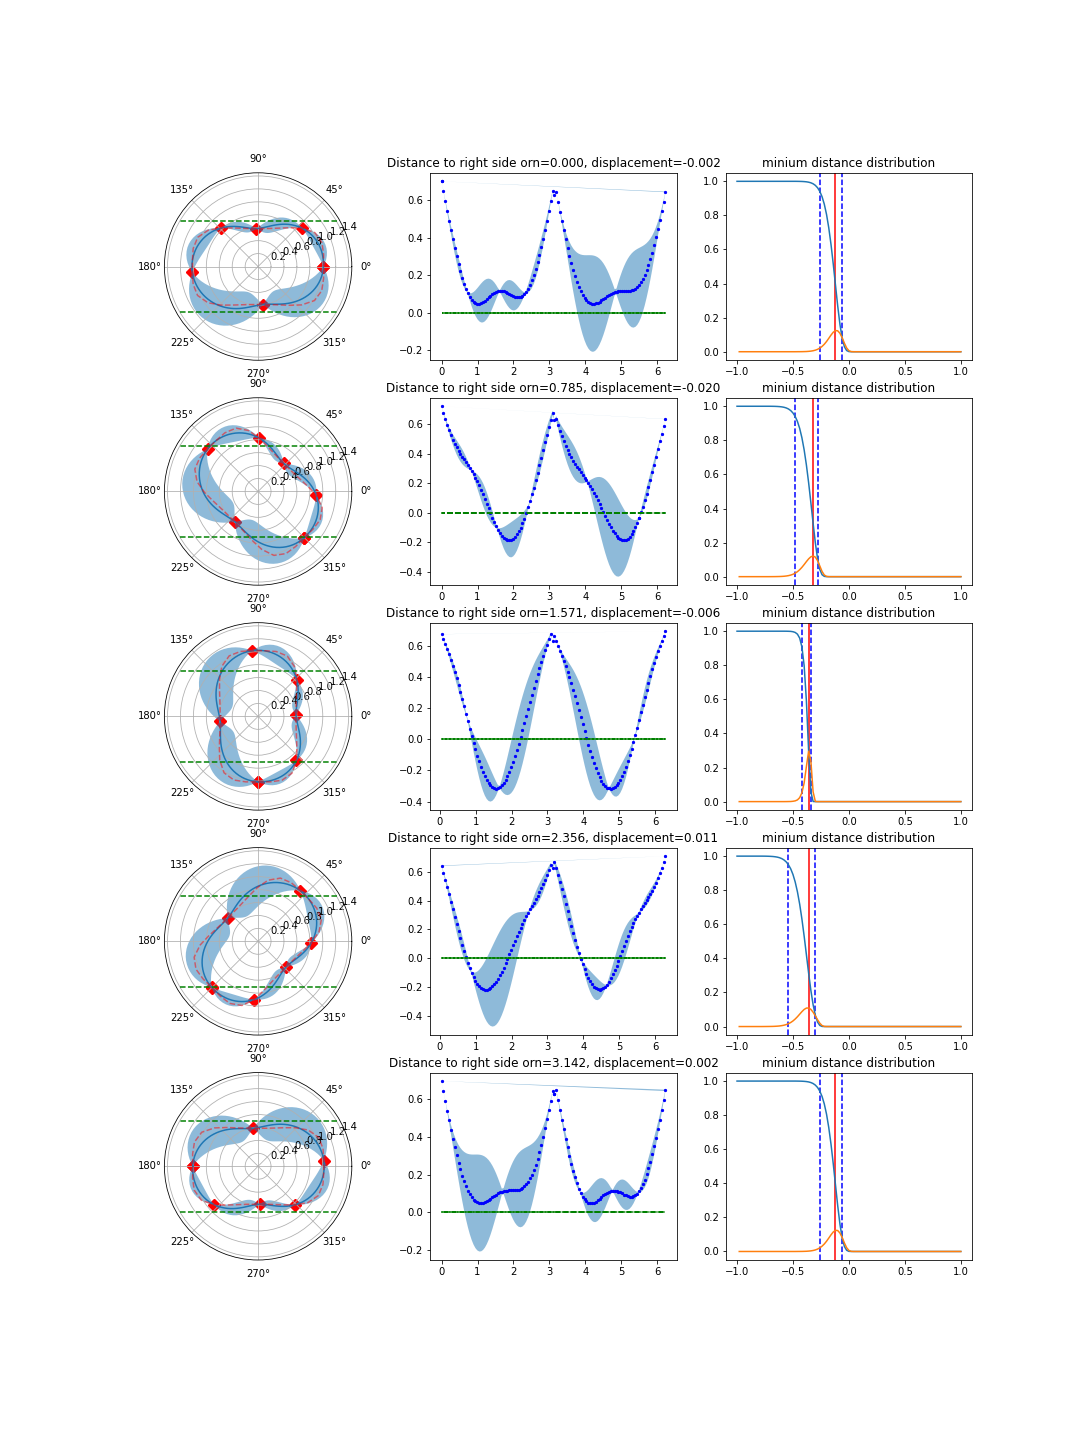

In [18]:
n_sample = 5
center = np.zeros(n_sample)
low = np.zeros(n_sample)
high = np.zeros(n_sample)
rot =  np.linspace(0, np.pi, n_sample)
fig = plt.figure(figsize=(15,4*n_sample))
for i, obj_orn in enumerate(rot):
  # left side
  if isinstance(x_pred, torch.Tensor):
    x_pred = x_pred.flatten().numpy()
  x_pred_rot = (x_pred - obj_orn) % (2*np.pi)
  mask_left = x_pred_rot < np.pi

  x_pred_left = x_pred_rot[mask_left]
  y_pred_left = y_pred[mask_left]
  mu_2left = hole_half_size - y_pred_left * np.sin(x_pred_left)
  std_2left = y_pred_std[mask_left] * np.sin(x_pred_left)
  left_min = np.min(mu_2left)

  # right side
  mask_right = x_pred_rot > np.pi
  x_pred_right = x_pred_rot[mask_right]
  y_pred_right = y_pred[mask_right]
  mu_2right = hole_half_size + y_pred_right * np.sin(x_pred_right)
  std_2right = - y_pred_std[mask_right] * np.sin(x_pred_right)
  right_min = np.min(mu_2right)

  obj_displacement = (left_min - right_min)/2

  dist = np.ones_like(y_pred)*0.63
  dist[mask_left] = mu_2left - obj_displacement
  dist[mask_right] = mu_2right + obj_displacement
  dist_std = np.zeros_like(y_pred)
  dist_std[mask_left] = std_2left
  dist_std[mask_right] = std_2right

  ax = fig.add_subplot(n_sample,3,3*i+1,projection='polar')
  ax.scatter(x_train.numpy()-obj_orn, y_train.numpy()*y_std+y_mean, c='r', marker='x', linewidth=10)
  ax.fill_between(
    x_pred_rot,
    y_lower,
    y_upper,
    alpha=0.5,
    label=r"95% confidence interval",
  )
  ax.plot(x_pred_rot, y_pred)
  ax.plot(X-obj_orn, y, 'r--', markersize=15, alpha=0.5)
  ax.plot(x_line, y_line, 'g--', markersize=15)
  ax.plot(x_line+np.pi, y_line, 'g--', markersize=15)

  ax = fig.add_subplot(n_sample, 3, 3*i+2)
  ax.fill_between(
    x_pred_rot,
    dist - dist_std*1.95,
    dist + dist_std*1.95,
    alpha=0.5,
    label=r"95% confidence interval",
  )
  ax.scatter(x_pred_rot, dist, s=5, c='b')
  ax.plot(x_pred_rot, np.zeros_like(x_pred), 'g--', markersize=15)
  ax.title.set_text(f'Distance to right side orn={obj_orn:.3f}, displacement={obj_displacement:.3f}')

  ax = fig.add_subplot(n_sample, 3, 3*i+3)
  # get minimum distance from the distribution. 
  x_min = torch.linspace(-1, 1, 101).unsqueeze(-1)
  dist = torch.tensor(dist)
  dist_std = torch.tensor(dist_std)
  x_normed = (x_min - dist)/dist_std
  log_cdf =gpytorch.log_normal_cdf(x_normed) 
  mask = log_cdf > -10
  cdf = torch.zeros_like(log_cdf)
  cdf[mask] = torch.exp(log_cdf[mask])
  cdf = torch.prod(1-cdf, dim=1)
  pdf = cdf[:-1] - cdf[1:]
  center_point = x_min[1:][pdf.argmax()]
  left_95_point = x_min[1:][pdf.cumsum(dim=0) < 0.95].max()
  right_95_point = x_min[1:][pdf.cumsum(dim=0) > 0.05].min()
  # only one line may be specified; full height
  ax.axvline(x = center_point, color = 'r')
  ax.axvline(x = left_95_point, color = 'b', linestyle = '--')
  ax.axvline(x = right_95_point, color = 'b', linestyle = '--')
  center[i] = center_point
  low[i] = left_95_point
  high[i] = right_95_point


  ax.plot(x_min.numpy(), cdf.numpy())
  ax.plot(x_min[1:].numpy(), pdf.numpy())
  ax.title.set_text('minium distance distribution')
  

In [19]:

n_sample = 121
center = np.zeros(n_sample)
low = np.zeros(n_sample)
high = np.zeros(n_sample)
rot =  np.linspace(0, np.pi, n_sample)
for i, obj_orn in enumerate(rot):
  # left side
  if isinstance(x_pred, torch.Tensor):
    x_pred = x_pred.flatten().numpy()
  x_pred_rot = (x_pred - obj_orn) % (2*np.pi)
  mask_left = x_pred_rot < np.pi

  x_pred_left = x_pred_rot[mask_left]
  y_pred_left = y_pred[mask_left]
  mu_2left = hole_half_size - y_pred_left * np.sin(x_pred_left)
  std_2left = y_pred_std[mask_left] * np.sin(x_pred_left)
  left_min = np.min(mu_2left)

  # right side
  mask_right = x_pred_rot > np.pi
  x_pred_right = x_pred_rot[mask_right]
  y_pred_right = y_pred[mask_right]
  mu_2right = hole_half_size + y_pred_right * np.sin(x_pred_right)
  std_2right = - y_pred_std[mask_right] * np.sin(x_pred_right)
  right_min = np.min(mu_2right)

  obj_displacement = (left_min - right_min)/2

  dist = np.ones_like(y_pred)*0.63
  dist[mask_left] = mu_2left - obj_displacement
  dist[mask_right] = mu_2right + obj_displacement
  dist_std = np.zeros_like(y_pred)
  dist_std[mask_left] = std_2left
  dist_std[mask_right] = std_2right

  # get minimum distance from the distribution. 
  x_min = torch.linspace(-1, 1, 601).unsqueeze(-1)
  dist = torch.tensor(dist)
  dist_std = torch.tensor(dist_std)
  x_normed = (x_min - dist)/dist_std
  log_cdf =gpytorch.log_normal_cdf(x_normed) 
  mask = log_cdf > -10
  cdf = torch.zeros_like(log_cdf)
  cdf[mask] = torch.exp(log_cdf[mask])
  cdf = torch.prod(1-cdf, dim=1)
  pdf = cdf[:-1] - cdf[1:]
  center_point = x_min[1:][pdf.argmax()]
  left_95_point = x_min[1:][pdf.cumsum(dim=0) < 0.95].max()
  right_95_point = x_min[1:][pdf.cumsum(dim=0) > 0.05].min()
  center[i] = center_point
  low[i] = left_95_point
  high[i] = right_95_point
  

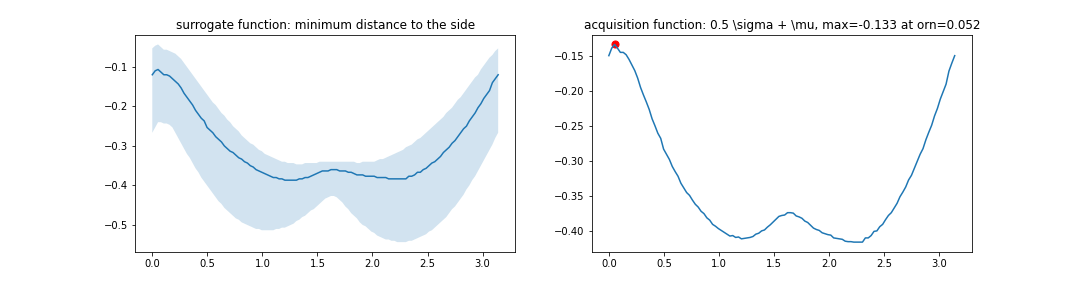

In [20]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1)
ax.fill_between(rot, low, high, alpha=0.2)
ax.plot(rot, center, label='center')
ax.title.set_text('surrogate function: minimum distance to the side')

ax = fig.add_subplot(1, 2, 2)
aq = 0.2*(high-center) + center
ax.plot(rot, aq)
aq_max = np.max(aq)
rot_max = rot[np.where(aq == aq_max)[0][0]]
ax.scatter(rot_max, aq_max, s=50, c='r')
ax.title.set_text(f'acquisition function: 0.5 \sigma + \mu, max={aq_max:.3f} at orn={rot_max:.3f}')


## 3D Case

In [21]:
# parameters
voxel_size = 0.02
obs_limit = 0.05

def get_hole_radius(theta):
  ep_long = 0.06
  ep_short = 0.036
  r = ep_long*ep_short/np.sqrt(ep_short**2*np.cos(theta)**2 + ep_long**2*np.sin(theta)**2)
  return r


In [22]:
import open3d as o3d
origin_pcd = o3d.io.read_point_cloud('assets/bottle.ply')
pcd = origin_pcd.voxel_down_sample(voxel_size=voxel_size)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


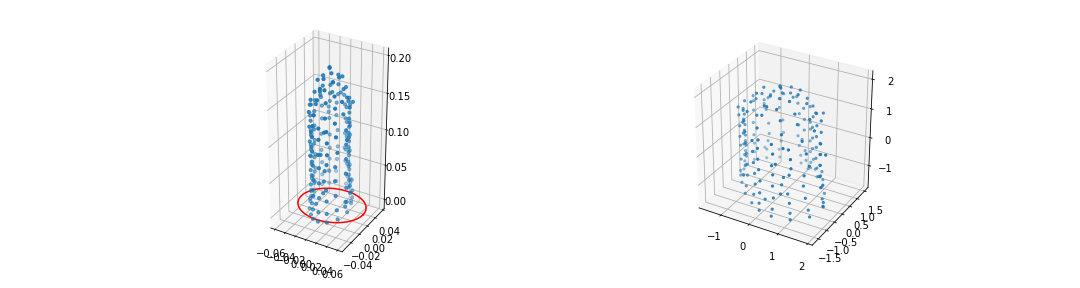

In [23]:
points = np.asarray(pcd.points)
fig = plt.figure(figsize=(15, 4))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_box_aspect((np.ptp(points[:, 0]), np.ptp(points[:, 1]), np.ptp(points[:,2])))
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=10)

hole_point_theta = np.linspace(0, 2*np.pi, 72)
hole_point_r = get_hole_radius(hole_point_theta)
hole_point_x = hole_point_r * np.cos(hole_point_theta)
hole_point_y = hole_point_r * np.sin(hole_point_theta)
hole_point_z = np.zeros_like(hole_point_theta)
ax.plot(hole_point_x, hole_point_y, hole_point_z, c='r')

# normalize data
mean = np.mean(points, axis=0)
std = np.std(points, axis=0)
points_normed = (points - mean)/std

def get_normed_hole_radius(theta):
  ep_long = 0.06 / std[0]
  ep_short = 0.036 / std[1]
  r = ep_long*ep_short/np.sqrt(ep_short**2*np.cos(theta)**2 + ep_long**2*np.sin(theta)**2)
  return r

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_box_aspect((np.ptp(points_normed[:, 0]), np.ptp(points_normed[:, 1]), np.ptp(points_normed[:,2])))
ax.scatter(points_normed[:, 0], points_normed[:, 1], points_normed[:, 2], s=5)

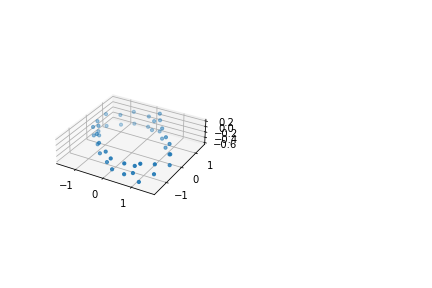

In [24]:
# get training data 
fig = plt.figure()

# normed observed point clouds
obs_z = 0.05
mask = (points[:, 2] > obs_z) & (points[:, 2] < obs_z + obs_limit)
obs_pcd_1 = points_normed[mask]
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_box_aspect((np.ptp(obs_pcd_1[:, 0]), np.ptp(obs_pcd_1[:, 1]), np.ptp(obs_pcd_1[:,2])))
ax.scatter(obs_pcd_1[:, 0], obs_pcd_1[:, 1], obs_pcd_1[:, 2], s=10)

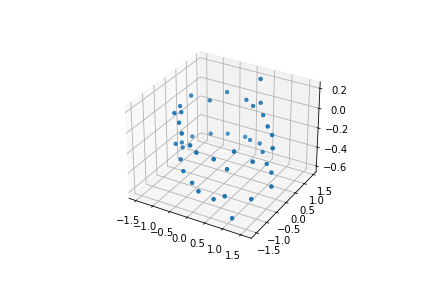

In [25]:
xyz = obs_pcd_1
theta_phi_train = np.stack((np.arctan2(xyz[:,1], xyz[:,0]), np.arctan2(xyz[:,2], np.linalg.norm(xyz[:,:2], axis=1))), axis=1)
r_train = np.linalg.norm(xyz, axis=1)
theta_phi_train = np.concatenate(
  [theta_phi_train, theta_phi_train+2*np.pi, theta_phi_train-2*np.pi], axis=0)
r_train = np.concatenate([r_train, r_train, r_train], axis=0)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
z = r_train * np.sin(theta_phi_train[:,1])
x = r_train * np.cos(theta_phi_train[:,1]) * np.cos(theta_phi_train[:,0])
y = r_train * np.cos(theta_phi_train[:,1]) * np.sin(theta_phi_train[:,0])
ax.scatter(x, y, z, s=10)

theta_phi_train = torch.tensor(theta_phi_train, dtype = torch.float64)
r_train = torch.tensor(r_train, dtype=torch.float64)

In [26]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood):
    super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = gpytorch.kernels.ScaleKernel(
      gpytorch.kernels.RBFKernel())

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.zeros_like(y_train, dtype=torch.float64))
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(theta_phi_train, r_train, likelihood)

In [27]:
hypers = {
  'covar_module.base_kernel.lengthscale': torch.tensor(0.572),
}
model_params = model.initialize(**hypers)

In [28]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

train_num = 100
for i in (pbar := trange(train_num)):
  # Zero gradients from previous iteration
  optimizer.zero_grad()
  # Output from model
  output = model(theta_phi_train)
  loss = -mll(output, r_train)
  loss.backward()
  pbar.set_description(f'Iter {i+1}/{train_num} - Loss: {loss.item():.3f}, lengthscale: {model.covar_module.base_kernel.lengthscale.item():.3f}')
  optimizer.step()

Iter 100/100 - Loss: 0.545, lengthscale: 0.997: 100%|██████████| 100/100 [00:00<00:00, 213.98it/s]


In [29]:

n_eval = 120
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  theta = torch.linspace(-np.pi, np.pi, n_eval, dtype=torch.float64)
  phi = torch.linspace(-np.pi/2, np.pi/2, n_eval, dtype=torch.float64)
  theta_phi_pred = torch.stack(torch.meshgrid(theta, phi), dim=-1)
  observed_pred = likelihood(model(theta_phi_pred))

r_pred = observed_pred.mean.detach().numpy()
r_pred_std = observed_pred.stddev.detach().numpy()
theta_phi_pred = theta_phi_pred.numpy()

/juno/u/chaoyi/miniconda3/envs/rl/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


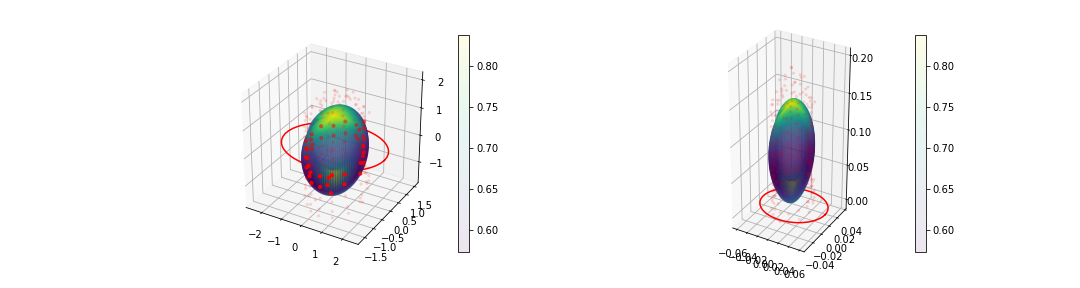

In [30]:
x_pred = r_pred * np.cos(theta_phi_pred[...,1]) * np.cos(theta_phi_pred[...,0])
y_pred = r_pred * np.cos(theta_phi_pred[...,1]) * np.sin(theta_phi_pred[...,0])
z_pred = r_pred * np.sin(theta_phi_pred[...,1])
pos_normed = np.stack((x_pred, y_pred, z_pred), axis=-1)
pos = pos_normed * std + mean
hole_points = np.stack([hole_point_x, hole_point_y, hole_point_z], axis=-1)
hole_points_normed = (hole_points - mean) / std
hole_points_normed -= np.mean(hole_points_normed, axis=0)
theta_phi_hole = np.stack((np.arctan2(hole_points_normed[:,1], hole_points_normed[:,0]), np.arctan2(hole_points_normed[:,2], np.linalg.norm(hole_points_normed[:,:2], axis=1))), axis=1)
r_hole = np.linalg.norm(hole_points_normed, axis=1)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_box_aspect((1, 1, 1))
cm = plt.cm.get_cmap('viridis')
sc = ax.scatter(x_pred, y_pred, z_pred, s=10, cmap=cm, c=r_pred_std, alpha=0.1)
plt.colorbar(sc)
ax.scatter(points_normed[:, 0], points_normed[:, 1], points_normed[:, 2], s=5,c='r', alpha=0.1)
ax.scatter(obs_pcd_1[:, 0], obs_pcd_1[:, 1], obs_pcd_1[:, 2], s=10, c='r')
ax.plot(hole_points_normed[..., 0], hole_points_normed[..., 1], hole_points_normed[..., 2], c='r')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_box_aspect((np.ptp(points[:, 0]), np.ptp(points[:, 1]), np.ptp(points[:,2])))
cm = plt.cm.get_cmap('viridis')
sc = ax.scatter(pos[..., 0], pos[..., 1], pos[..., 2], s=10, cmap=cm, c=r_pred_std, alpha=0.1)
plt.colorbar(sc)
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5,c='r', alpha=0.1)
ax.plot(hole_point_x, hole_point_y, hole_point_z, c='r')

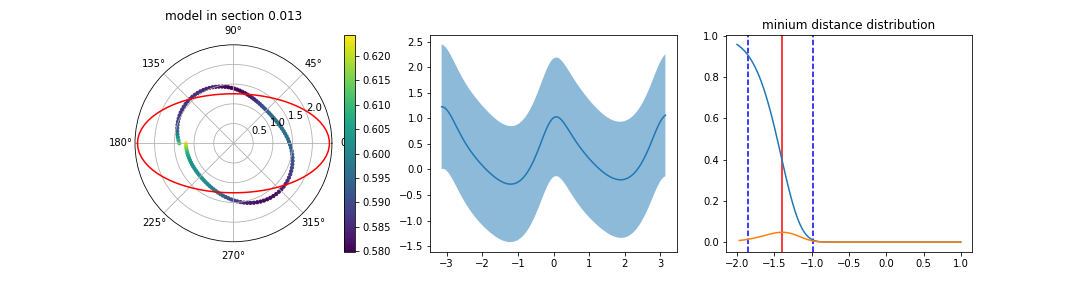

In [73]:
obj_theta = -np.pi/4
obj_phi = 0
analysis_idx = n_eval // 2

theta_phi_pred_rot = theta_phi_pred.copy()
theta_phi_pred_rot[..., 0] = theta_phi_pred_rot[..., 0] - obj_theta
theta_phi_pred_rot[..., 1] = theta_phi_pred_rot[..., 1] - obj_phi

fig = plt.figure(figsize=(15, 4))

theta = theta_phi_pred_rot[:, analysis_idx, 0]
phi = theta_phi_pred_rot[:,analysis_idx , 1]
r = r_pred[:, analysis_idx]
r_hole = get_normed_hole_radius(theta)
r_std = r_pred_std[:, analysis_idx]

ax = fig.add_subplot(1, 3, 1, projection='polar')
sc = ax.scatter(theta, r, s=10, c=r_std)
plt.colorbar(sc)
ax.plot(theta, r_hole, c='r')
ax.title.set_text(f'model in section {phi[0].item():.3f}')

ax = fig.add_subplot(1, 3, 2)
ax.plot(theta, r_hole-r)
ax.fill_between(theta, r_hole-r-r_std*1.95, r_hole-r+r_std*1.95, alpha=0.5)

ax = fig.add_subplot(1, 3, 3)

# get minimum distance from the distribution. 
x_min = torch.linspace(-2, 1, 101).unsqueeze(-1)
dist = torch.tensor(r_hole-r)
dist_std = torch.tensor(r_std)
x_normed = (x_min - dist)/dist_std
log_cdf =gpytorch.log_normal_cdf(x_normed) 
mask = log_cdf > -10
cdf = torch.zeros_like(log_cdf)
cdf[mask] = torch.exp(log_cdf[mask])
cdf = torch.prod(1-cdf, dim=1)
pdf = cdf[:-1] - cdf[1:]
center_point = x_min[1:][pdf.argmax()]
left_95_point = x_min[1:][pdf.cumsum(dim=0) < 0.95].max()
right_95_point = x_min[1:][pdf.cumsum(dim=0) > 0.05].min()
# only one line may be specified; full height
ax.axvline(x = center_point, color = 'r')
ax.axvline(x = left_95_point, color = 'b', linestyle = '--')
ax.axvline(x = right_95_point, color = 'b', linestyle = '--')
center[i] = center_point
low[i] = left_95_point
high[i] = right_95_point

ax.plot(x_min.numpy(), cdf.numpy())
ax.plot(x_min[1:].numpy(), pdf.numpy())
ax.title.set_text('minium distance distribution')

In [74]:

center = np.zeros(n_eval)
low = np.zeros(n_eval)
high = np.zeros(n_eval)
x_size = 400
for analysis_idx in range(n_eval):
  # get minimum distance from the distribution. 
  theta = theta_phi_pred_rot[:, analysis_idx, 0]
  phi = theta_phi_pred_rot[:,analysis_idx , 1]
  r = r_pred[:, analysis_idx]
  r_hole = get_normed_hole_radius(theta)
  r_std = r_pred_std[:, analysis_idx]
  x_min = torch.linspace(-2, 2, x_size).unsqueeze(-1)
  dist = torch.tensor(r_hole-r)
  dist_std = torch.tensor(r_std)
  x_normed = (x_min - dist)/dist_std
  log_cdf =gpytorch.log_normal_cdf(x_normed) 
  mask = log_cdf > -10
  cdf = torch.zeros_like(log_cdf)
  cdf[mask] = torch.exp(log_cdf[mask])
  cdf = torch.prod(1-cdf, dim=1)
  pdf = cdf[:-1] - cdf[1:]
  center_point = x_min[1:][pdf.argmax()]
  left_95_point = x_min[1:][pdf.cumsum(dim=0) < 0.95].max()
  right_95_point = x_min[1:][pdf.cumsum(dim=0) > 0.05].min()
  # only one line may be specified; full height
  center[analysis_idx] = center_point.item()
  low[analysis_idx] = left_95_point.item()
  high[analysis_idx] = right_95_point.item()

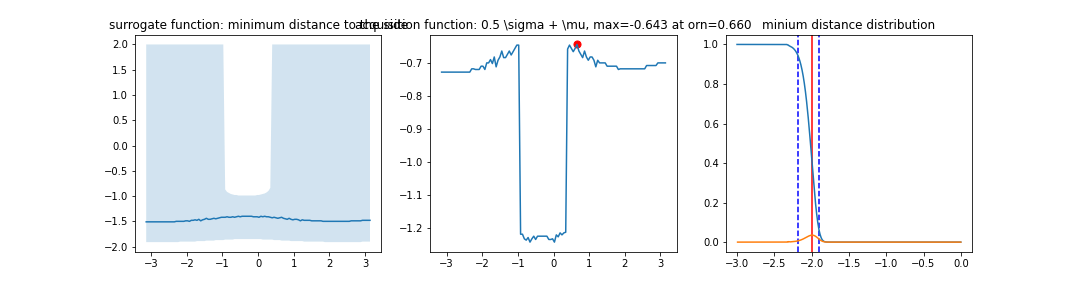

In [75]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1)
phi = np.linspace(-np.pi, np.pi, n_eval)
ax.fill_between(phi, low, high, alpha=0.2)
ax.plot(phi, center, label='center')
ax.title.set_text('surrogate function: minimum distance to the side')

ax = fig.add_subplot(1, 3, 2)
aq = 0.2*(low-high) + center
ax.plot(phi, aq)
aq_max = np.max(aq)
rot_max = phi[np.where(aq == aq_max)[0][0]]
ax.scatter(rot_max, aq_max, s=50, c='r')
ax.title.set_text(f'acquisition function: 0.5 \sigma + \mu, max={aq_max:.3f} at orn={rot_max:.3f}')

ax = fig.add_subplot(1, 3, 3)
# get minimum distance from the distribution. 
x_min = torch.linspace(-3, 0, 400).unsqueeze(-1)
dist = torch.tensor(center)
dist_std = torch.tensor((center-high)/1.95)
x_normed = (x_min - dist)/dist_std
log_cdf = gpytorch.log_normal_cdf(x_normed) 
mask = log_cdf > -10
cdf = torch.zeros_like(log_cdf)
cdf[mask] = torch.exp(log_cdf[mask])
cdf = torch.prod(1-cdf, dim=1)
pdf = cdf[:-1] - cdf[1:]
center_point = x_min[1:][pdf.argmax()]

right_95_point = x_min[1:][pdf.cumsum(dim=-1) < 0.95].max()
try:
  left_95_point = x_min[1:][pdf.cumsum(dim=-1) > 0.05].min()
except:
  left_95_point = -1

# only one line may be specified; full height
ax.axvline(x = center_point, color = 'r')
ax.axvline(x = left_95_point, color = 'b', linestyle = '--')
ax.axvline(x = right_95_point, color = 'b', linestyle = '--')
center[i] = center_point
low[i] = left_95_point
high[i] = right_95_point

ax.plot(x_min.numpy(), cdf.numpy())
ax.plot(x_min[1:].numpy(), pdf.numpy())
ax.title.set_text('minium distance distribution')


In [76]:
theta_sample = 30
phi_sample = 1

all_center = np.zeros((theta_sample, phi_sample))
all_low = np.zeros((theta_sample, phi_sample))
all_high = np.zeros((theta_sample, phi_sample))
for i, obj_theta in enumerate(np.linspace(-np.pi, np.pi, theta_sample)):
  # for j, obj_phi in enumerate(np.linspace(-np.pi/2, np.pi/2, phi_sample)):
  for j, obj_phi in enumerate([0]):
    theta_phi_pred_rot = theta_phi_pred.copy()
    theta_phi_pred_rot[..., 0] = theta_phi_pred_rot[..., 0] - obj_theta
    theta_phi_pred_rot[..., 1] = theta_phi_pred_rot[..., 1] - obj_phi
    center = np.zeros(n_eval)
    low = np.zeros(n_eval)
    high = np.zeros(n_eval)
    x_size = 100
    for analysis_idx in range(n_eval):
      # get minimum distance from the distribution. 
      theta = theta_phi_pred_rot[:, analysis_idx, 0]
      phi = theta_phi_pred_rot[:,analysis_idx , 1]
      r = r_pred[:, analysis_idx]
      r_hole = get_normed_hole_radius(theta)
      r_std = r_pred_std[:, analysis_idx]
      x_min = torch.linspace(-2, 2, x_size).unsqueeze(-1)
      dist = torch.tensor(r_hole-r)
      dist_std = torch.tensor(r_std)
      x_normed = (x_min - dist)/dist_std
      log_cdf =gpytorch.log_normal_cdf(x_normed) 
      mask = log_cdf > -10
      cdf = torch.zeros_like(log_cdf)
      cdf[mask] = torch.exp(log_cdf[mask])
      cdf = torch.prod(1-cdf, dim=1)
      pdf = cdf[:-1] - cdf[1:]
      center_point = x_min[1:][pdf.argmax()]
      left_95_point = x_min[1:][pdf.cumsum(dim=0) < 0.95].max()
      right_95_point = x_min[1:][pdf.cumsum(dim=0) > 0.05].min()
      # only one line may be specified; full height
      center[analysis_idx] = center_point.item()
      low[analysis_idx] = left_95_point.item()
      high[analysis_idx] = right_95_point.item()
    x_min = torch.linspace(-3, 0, 400).unsqueeze(-1)
    dist = torch.tensor(center)
    dist_std = torch.tensor((center-high)/2/1.95)
    x_normed = (x_min - dist)/dist_std
    log_cdf = gpytorch.log_normal_cdf(x_normed) 
    mask = log_cdf > -10
    cdf = torch.zeros_like(log_cdf)
    cdf[mask] = torch.exp(log_cdf[mask])
    cdf = torch.prod(1-cdf, dim=1)
    pdf = cdf[:-1] - cdf[1:]
    center_point = x_min[1:][pdf.argmax()]

    right_95_point = x_min[1:][pdf.cumsum(dim=-1) < 0.95].max()
    left_95_point = x_min[1:][pdf.cumsum(dim=-1) > 0.05].min()

    all_center[i, j] = center_point
    all_low[i, j] = left_95_point
    all_high[i, j] = right_95_point

In [77]:
import seaborn as sns

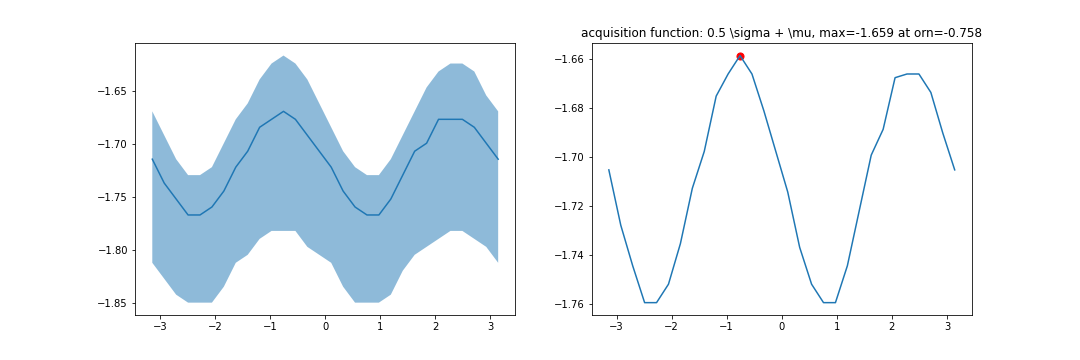

In [78]:
fig = plt.figure(figsize=(15, 5))
phi = np.linspace(-np.pi, np.pi, theta_sample)
ax = fig.add_subplot(1, 2, 1)
ax.plot(np.linspace(-np.pi, np.pi, theta_sample), all_center[:, 0])
ax.fill_between(np.linspace(-np.pi, np.pi, theta_sample), all_low[:, 0], all_high[:, 0], alpha=0.5)
ax = fig.add_subplot(1, 2, 2)
aq = 0.2*(all_high[:,0]-all_center[:,0]) + all_center[:,0]
ax.plot(np.linspace(-np.pi, np.pi, theta_sample), aq)
aq_max = np.max(aq)
rot_max = phi[np.where(aq == aq_max)[0][0]]
ax.scatter(rot_max, aq_max, s=50, c='r')
ax.title.set_text(f'acquisition function: 0.5 \sigma + \mu, max={aq_max:.3f} at orn={rot_max:.3f}')